In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

In [221]:
df=pd.read_csv('CARS.csv')

In [222]:
df.shape

(17145, 17)

In [223]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17145 entries, 0 to 17144
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Unnamed: 0            17145 non-null  int64 
 1   City                  17145 non-null  object
 2   Brand                 17145 non-null  object
 3   Model                 17145 non-null  object
 4   Year of Manufacture   17145 non-null  int64 
 5   Body Type             17145 non-null  object
 6   Color                 17145 non-null  object
 7   Engine                17145 non-null  object
 8   Mileage               17145 non-null  object
 9   Transmission          17145 non-null  object
 10  Drivetrain            17145 non-null  object
 11  New                   17145 non-null  object
 12  Condition             17130 non-null  object
 13  Price                 17145 non-null  object
 14  Number of Seats       14823 non-null  object
 15  Owners                14183 non-null

In [224]:
df.isnull().sum()

Unnamed: 0                 0
City                       0
Brand                      0
Model                      0
Year of Manufacture        0
Body Type                  0
Color                      0
Engine                     0
Mileage                    0
Transmission               0
Drivetrain                 0
New                        0
Condition                 15
Price                      0
Number of Seats         2322
Owners                  2962
Market Assembled For    2505
dtype: int64

In [225]:
df.nunique()

Unnamed: 0              17145
City                       64
Brand                     144
Model                    1175
Year of Manufacture        62
Body Type                  20
Color                      17
Engine                   1747
Mileage                  4908
Transmission                4
Drivetrain                  3
New                         2
Condition                   4
Price                    1936
Number of Seats            15
Owners                      9
Market Assembled For        9
dtype: int64

In [226]:
df.head()

,Unnamed: 0,City,Brand,Model,Year of Manufacture,Body Type,Color,Engine,Mileage,Transmission,Drivetrain,New,Condition,Price,Number of Seats,Owners,Market Assembled For
0,0,Baku,Hyundai,Sonata,2014,Sedan,Black,2.4 L/178 h.p./Petrol,123 000 km,Automatic,Front,No,"No dents, not painted",23 900 AZN,5.0,1.0,Europe
1,1,Baku,Fiat,Fiorino,2022,Minivan,White,1.4 L/77 h.p./Gas,0 km,Manual,Front,Yes,"No dents, not painted",30 400 AZN,5.0,1.0,Europe
2,2,Baku,Lexus,ES 300h,2022,Sedan,White,2.5 L/215 h.p./Hybrid,0 km,Automatic,Front,Yes,"No dents, not painted",63 500 USD,5.0,1.0,Europe
3,3,Baku,Nissan,Tiida,2012,Hatchback,Golden,1.5 L/110 h.p./Petrol,36 000 km,Automatic,Front,No,"No dents, not painted",14 300 AZN,5.0,1.0,Japan
4,4,Baku,BMW,520,2014,Sedan,White,2.0 L/245 h.p./Petrol,126 500 km,Automatic,Rear,No,"No dents, not painted",38 500 AZN,4.0,1.0,Official Dealer


In [227]:
df['Number of Seats'] = df['Number of Seats'].replace('8+', '8').astype(float)
df['Number of Seats'].unique()

array([ 5.,  4.,  7.,  2.,  3.,  6.,  1., nan,  8.])

In [228]:
df['Market Assembled For'].unique()

array(['Europe', 'Japan', 'Official Dealer', 'America', 'Russia',
       'South Korea', 'Dubai', 'Other', nan, 'China'], dtype=object)

In [229]:
df['Owners'] = df['Owners'].replace('4 və daha çox', '4').astype(float)
df['Owners'].unique()

array([ 1.,  2.,  0.,  3., nan,  4.])

In [230]:
df["Number of Seats"] = df.groupby(["Brand", "Model", "Body Type"])["Number of Seats"].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else x.mean()))

df.isnull().sum()

Unnamed: 0                 0
City                       0
Brand                      0
Model                      0
Year of Manufacture        0
Body Type                  0
Color                      0
Engine                     0
Mileage                    0
Transmission               0
Drivetrain                 0
New                        0
Condition                 15
Price                      0
Number of Seats          129
Owners                  2962
Market Assembled For    2505
dtype: int64

In [231]:
df['Number of Seats'] = df.groupby('Body Type')['Number of Seats'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else x.mean()))

df['Number of Seats'] = df['Number of Seats'].astype(float).astype(int)  
print(df['Number of Seats'].dtypes) 

int64


In [232]:
df['Mileage']=df['Mileage'].str.replace(' ','')
df['Mileage']=df['Mileage'].str.replace('km','')

In [233]:
df['Year of Manufacture']=pd.to_datetime(df['Year of Manufacture'].astype(str),format='%Y')
df['Year of Manufacture'] = df['Year of Manufacture'].dt.year
df['Year of Manufacture'].head()

0    2014
1    2022
2    2022
3    2012
4    2014
Name: Year of Manufacture, dtype: int32

In [234]:
df['Owners'] = df.groupby(['Mileage', 'Year of Manufacture'])['Owners'].transform(
    lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else x.dropna().median())
)

In [235]:
df['Owners'] = df.groupby(['Model', 'Year of Manufacture'])['Owners'].transform(
    lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else x.dropna().median())
)

In [236]:
df.loc[df["Owners"].isna() & (df["Year of Manufacture"] > 2018), "Owners"] = 1  
df.loc[df["Owners"].isna() & (df["Year of Manufacture"] < 2005), "Owners"] = 3 
df.loc[df["Owners"].isna(), "Owners"] = 2

In [237]:
df['Market Assembled For'] = df.groupby(["Brand", "Model"])['Market Assembled For'].transform(
    lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else "Unknown")
)

In [238]:
df['Condition'] = df.groupby(['Mileage', 'Year of Manufacture'])['Condition'].transform(
    lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else 'No dents, not painted')
)

In [239]:
df.isnull().sum().sum()

np.int64(0)

In [240]:
df.City.nunique()

64

In [241]:
region_groups = {
    'Baku': ['Baku'],
    'Sumgayit': ['Sumgayit'],
    'Absheron': ['Khirdalan'],
    'Ganja-Dashkasan': ['Dalimammadli', 'Ganja', 'Naftalan', 'Goranboy', 'Goygol', 'Samukh', 'Dashkasan'],
    'Gazakh-Tovuz': ['Gazakh', 'Tovuz', 'Agstafa', 'Gadabay', 'Shamkir'],
    'Sheki-Zaqatala': ['Sheki', 'Zagatala', 'Balakan', 'Gabala', 'Oghuz', 'Gakh'],
    'Lankaran-Astara': ['Lankaran', 'Astara', 'Masalli', 'Jalilabad', 'Lerik', 'Yardimli'],
    'Nakhchivan': ['Nakhchivan', 'Babak', 'Sharur', 'Ordubad'],
    'Guba-Khachmaz': ['Khudat', 'Guba', 'Khachmaz', 'Shabran', 'Gusar', 'Siyazan', 'Khizi'],
    'Central Aran': ['Agdash', 'Barda', 'Kurdamir', 'Ujar', 'Zardab', 'Mingachevir', 'Yevlakh', 'Goychay'],
    'Mil-Mughan': ['Beylagan', 'Imishli', 'Saatli', 'Sabirabad'],
    'Shirvan-Salyan': ['Salyan', 'Bilasuvar', 'Hajigabul', 'Neftchala', 'Shirvan'],
    'Karabakh': ['Agjabadi', 'Agdam', 'Fuzuli', 'Khojaly', 'Khojavend', 'Shusha', 'Tartar'],
    'East Zangezur': ['Jabrayil', 'Kalbajar', 'Qubadli', 'Lachin', 'Zangilan'],
    'Mountainous Shirvan': ['Agsu', 'Ismayilli', 'Gobustan', 'Shamakhi']
}
region_map = {city: region for region, cities in region_groups.items() for city in cities}
df['Region'] = df['City'].map(region_map)


In [242]:
df.Region.unique()

array(['Baku', 'Lankaran-Astara', 'Sumgayit', 'Ganja-Dashkasan',
       'Shirvan-Salyan', 'Sheki-Zaqatala', 'Nakhchivan', 'Gazakh-Tovuz',
       'Absheron', 'Karabakh', 'Guba-Khachmaz', 'Central Aran',
       'Mountainous Shirvan', 'Mil-Mughan', 'East Zangezur'], dtype=object)

In [243]:
df=df.drop(['Unnamed: 0','City'],axis=1)

In [244]:
df[['Engine Volume','Horse Power','Fuel']]=df['Engine'].str.split('/',expand=True)
df['Engine Volume'] = df['Engine Volume'].str.replace(' L', '', regex=False)
df['Horse Power'] = df['Horse Power'].str.replace(' h.p.', '', regex=False)
df['Fuel']=df['Fuel']
df=df.drop(['Engine'],axis=1)

In [245]:
df[['Has_Dents','Is_Painted']]=df['Condition'].str.split(',',expand=True)
df=df.drop('Condition',axis=1)

In [246]:
df[['Price1','Price2','Currency']]=df['Price'].str.split(' ',expand=True)
df['Price']=df['Price1']+df['Price2']
df[['Price','Currency']]

,Price,Currency
0,23900,AZN
1,30400,AZN
2,63500,USD
3,14300,AZN
4,38500,AZN
...,...,...
17140,36500,USD
17141,41500,USD
17142,3500,AZN
17143,6500,AZN


In [247]:
df['Currency'].isnull().sum()

np.int64(4)

In [248]:
df=df.dropna(subset=['Currency'])

In [249]:
df['Price']=df['Price'].astype(float)
exchange_rates = {'USD': 1.7, 'EUR': 1.8, 'AZN': 1}
df['Final_price'] = df['Price'] * df['Currency'].map(exchange_rates)
df=df.drop(['Price','Price1','Price2','Currency'],axis=1)

In [250]:
df.dtypes

Brand                    object
Model                    object
Year of Manufacture       int32
Body Type                object
Color                    object
Mileage                  object
Transmission             object
Drivetrain               object
New                      object
Number of Seats           int64
Owners                  float64
Market Assembled For     object
Region                   object
Engine Volume            object
Horse Power              object
Fuel                     object
Has_Dents                object
Is_Painted               object
Final_price             float64
dtype: object

In [251]:
df['Owners'].unique()

array([1., 2., 0., 3., 4.])

In [252]:
df[['Mileage', 'Owners', 'Horse Power']]=df[['Mileage', 'Owners', 'Horse Power']].astype(int)
df['Engine Volume']=df['Engine Volume'].astype(float)

In [253]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Year of Manufacture,17141.0,2010.753982,8.399289,1938.0,2007.0,2012.0,2016.0,2023.0
Mileage,17141.0,173230.524415,209135.141050,0.0,70000.0,157000.0,235000.0,9999999.0
Number of Seats,17141.0,5.056531,0.907965,1.0,5.0,5.0,5.0,8.0
Owners,17141.0,1.290531,0.663921,0.0,1.0,1.0,2.0,4.0
Engine Volume,17141.0,2.291313,1.310383,0.0,1.6,2.0,2.5,15.0
Horse Power,17141.0,186.772242,100.996174,1.0,115.0,167.0,240.0,1410.0
Final_price,17141.0,39533.955242,54373.422669,1000.0,12800.0,23000.0,43900.0,620500.0


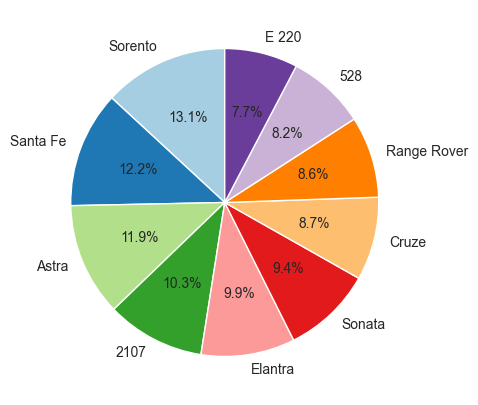

In [254]:
pie_data=df['Model'].value_counts().head(10)
plt.figure(figsize=(5,5))
plt.pie(pie_data,labels=pie_data.index,autopct="%1.1f%%", startangle=90, colors=plt.cm.Paired.colors)
plt.show()

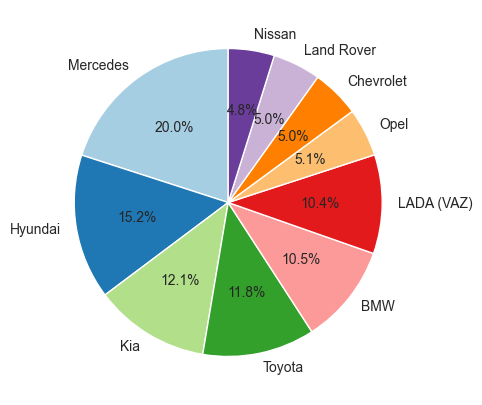

In [255]:
pie_data=df['Brand'].value_counts().head(10)
plt.figure(figsize=(5,5))
plt.pie(pie_data,labels=pie_data.index,autopct="%1.1f%%", startangle=90, colors=plt.cm.Paired.colors)
plt.show()

<Axes: xlabel='Body Type'>

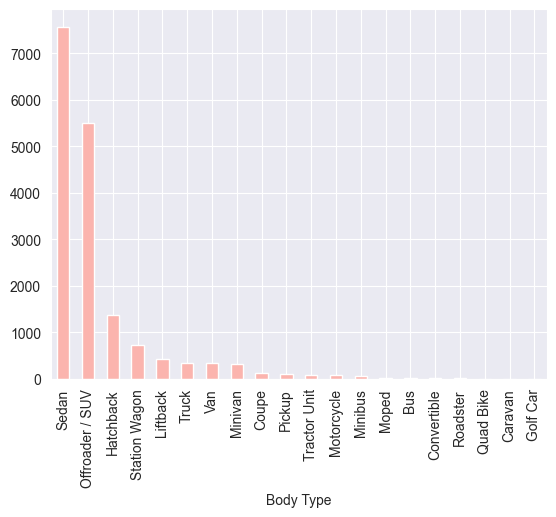

In [256]:
df['Body Type'].value_counts().plot.bar()

<Axes: xlabel='Drivetrain'>

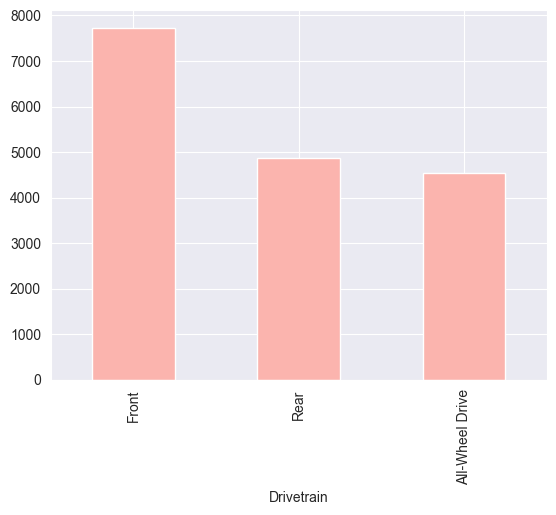

In [257]:
df['Drivetrain'].value_counts().plot.bar()

<Axes: xlabel='New'>

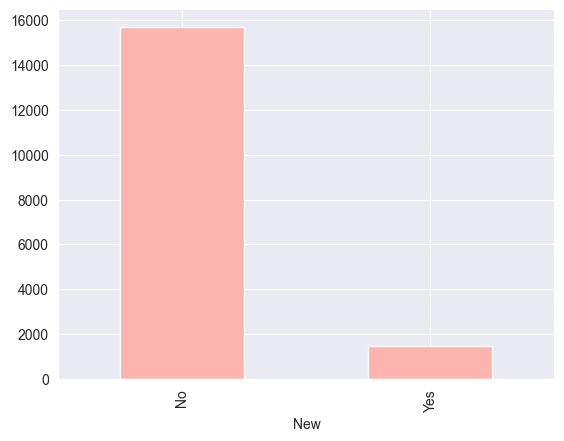

In [258]:
df['New'].value_counts().plot.bar()

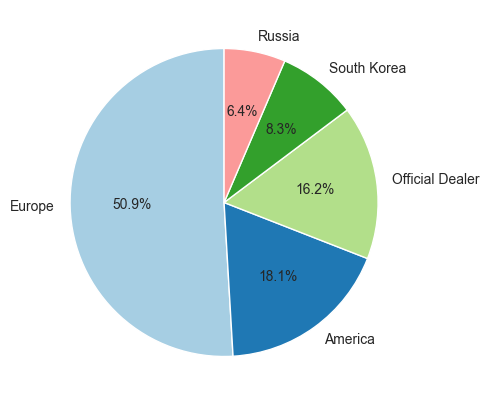

In [259]:
pie_data=df['Market Assembled For'].value_counts().head(5)
plt.figure(figsize=(5,5))
plt.pie(pie_data,labels=pie_data.index,autopct="%1.1f%%", startangle=90, colors=plt.cm.Paired.colors)
plt.show()

In [260]:
df.select_dtypes(exclude=['object'])

,Year of Manufacture,Mileage,Number of Seats,Owners,Engine Volume,Horse Power,Final_price
0,2014,123000,5,1,2.4,178,23900.0
1,2022,0,5,1,1.4,77,30400.0
2,2022,0,5,1,2.5,215,107950.0
3,2012,36000,5,1,1.5,110,14300.0
4,2014,126500,4,1,2.0,245,38500.0
...,...,...,...,...,...,...,...
17140,2018,33000,5,0,2.0,184,62050.0
17141,2017,59800,7,1,3.0,340,70550.0
17142,2016,50000,2,3,0.2,22,3500.0
17143,1995,452134,5,1,1.8,122,6500.0


In [261]:
df.select_dtypes(exclude='object')

,Year of Manufacture,Mileage,Number of Seats,Owners,Engine Volume,Horse Power,Final_price
0,2014,123000,5,1,2.4,178,23900.0
1,2022,0,5,1,1.4,77,30400.0
2,2022,0,5,1,2.5,215,107950.0
3,2012,36000,5,1,1.5,110,14300.0
4,2014,126500,4,1,2.0,245,38500.0
...,...,...,...,...,...,...,...
17140,2018,33000,5,0,2.0,184,62050.0
17141,2017,59800,7,1,3.0,340,70550.0
17142,2016,50000,2,3,0.2,22,3500.0
17143,1995,452134,5,1,1.8,122,6500.0


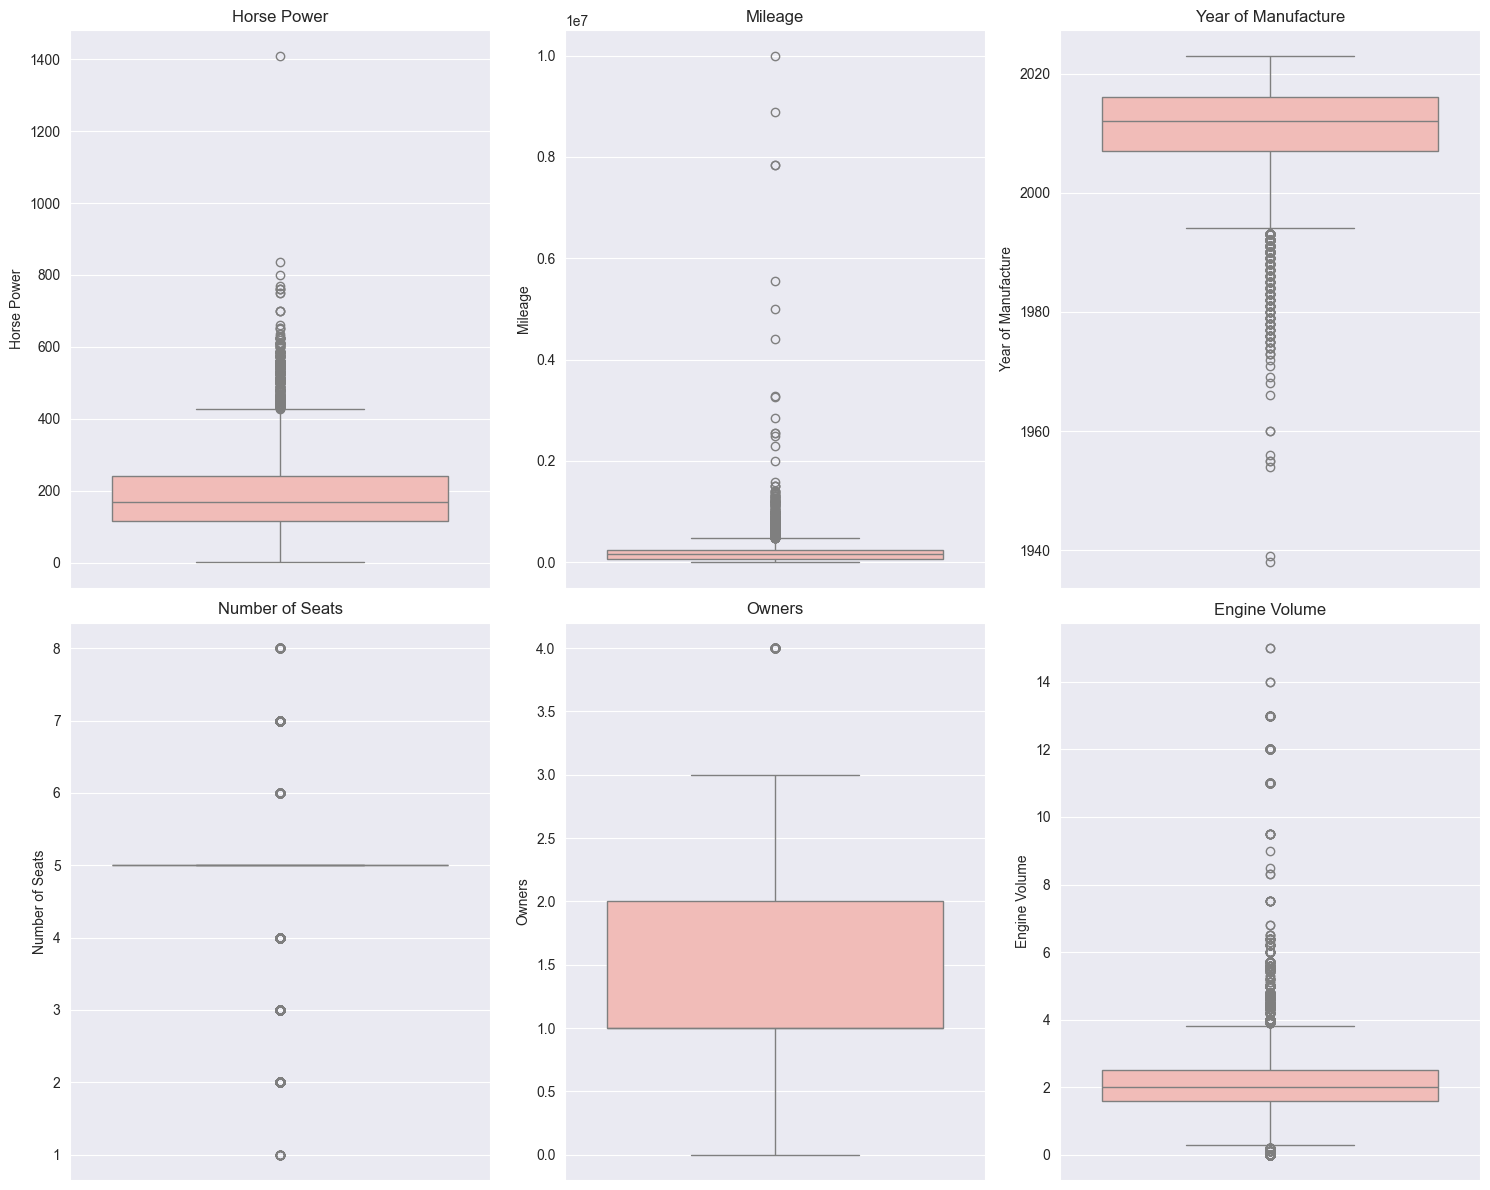

In [262]:
plt.figure(figsize=(15, 12))

features = ['Horse Power', 'Mileage', 'Year of Manufacture', 
            'Number of Seats', 'Owners', 'Engine Volume']

for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[feature])
    plt.title(feature)

plt.tight_layout()
plt.show()

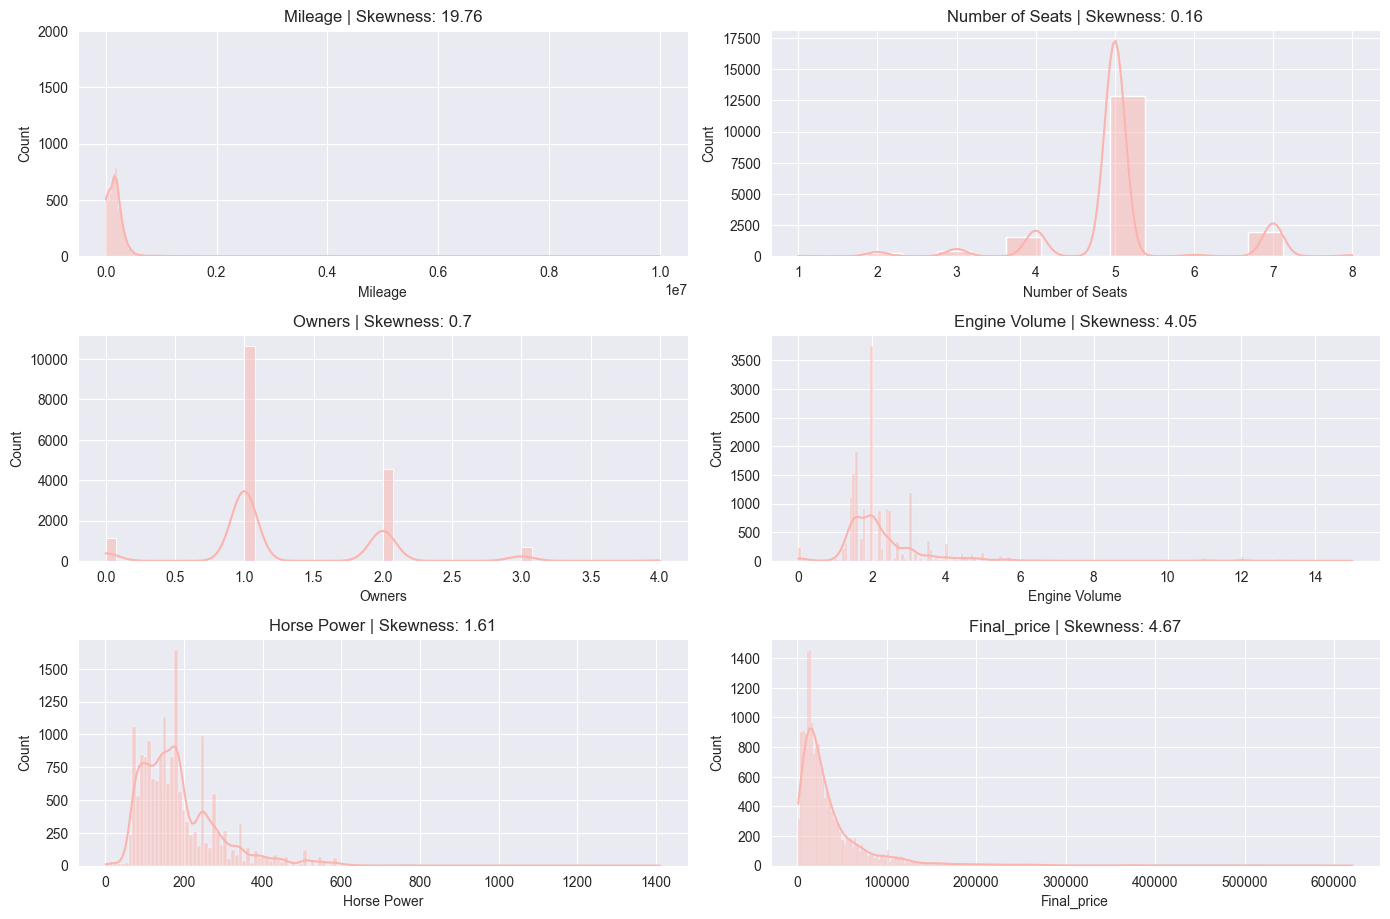

In [263]:
sns.set_style("darkgrid")

numerical_columns = df.select_dtypes(include=["int64", "float64"]).columns

plt.figure(figsize=(14, len(numerical_columns) * 3))
for idx, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 2, idx)
    sns.histplot(df[feature], kde=True)
    plt.title(f"{feature} | Skewness: {round(df[feature].skew(), 2)}")

plt.tight_layout()
plt.show()


<Axes: xlabel='Owners', ylabel='Mileage'>

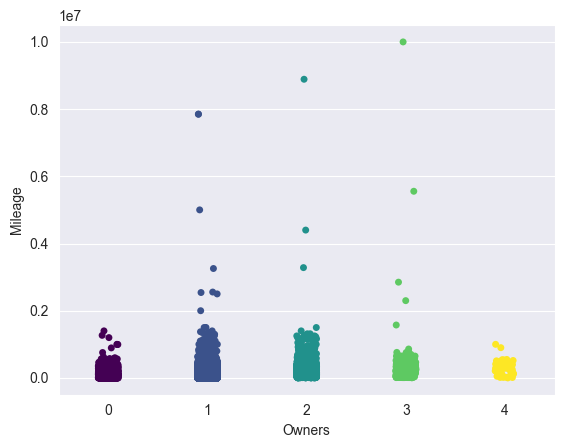

In [264]:
sns.stripplot(
    x="Owners",
    y="Mileage",
    data=df,
    jitter=True,
    hue="Owners",  
    palette="viridis",
    legend=False  
)


<Figure size 1000x600 with 0 Axes>

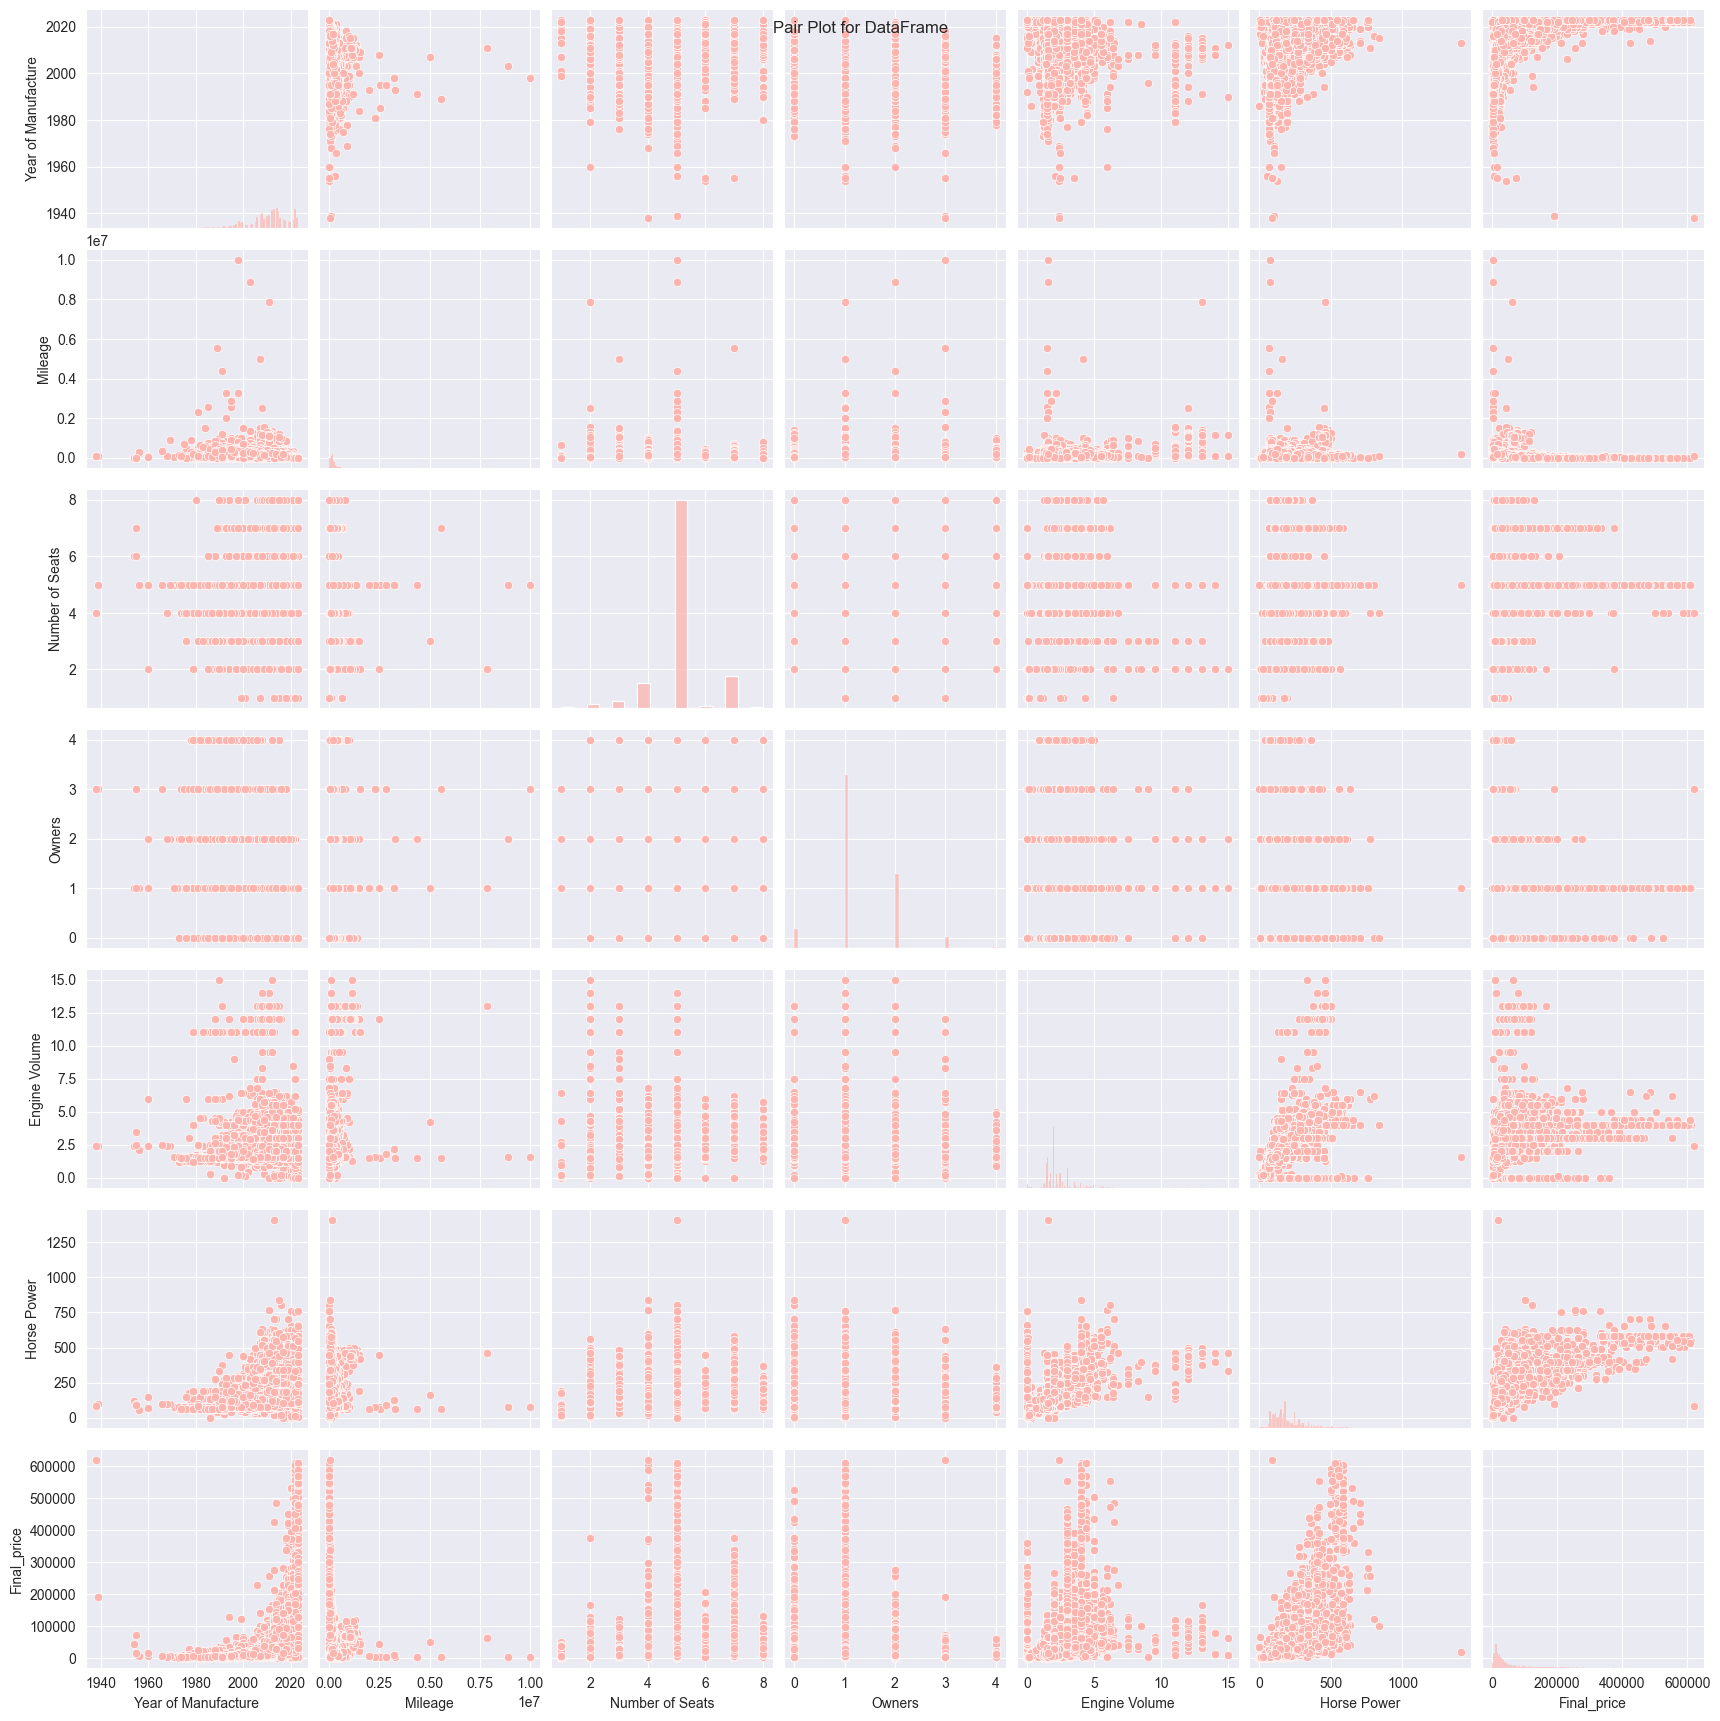

In [265]:
sns.set_palette("Pastel1")

plt.figure(figsize=(10, 6))

sns.pairplot(df)

plt.suptitle('Pair Plot for DataFrame')
plt.show()


<Axes: xlabel='Owners', ylabel='Mileage'>

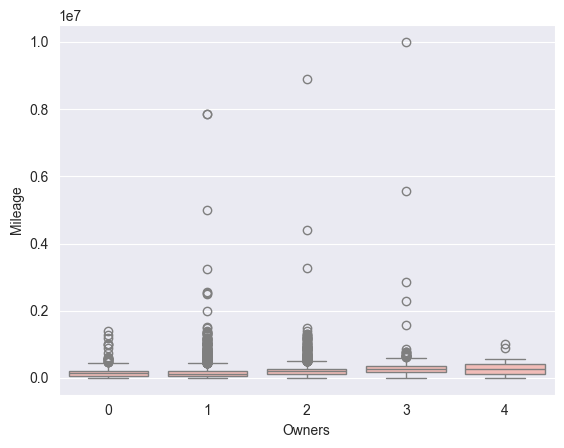

In [266]:
sns.boxplot(x='Owners', y='Mileage', data=df)

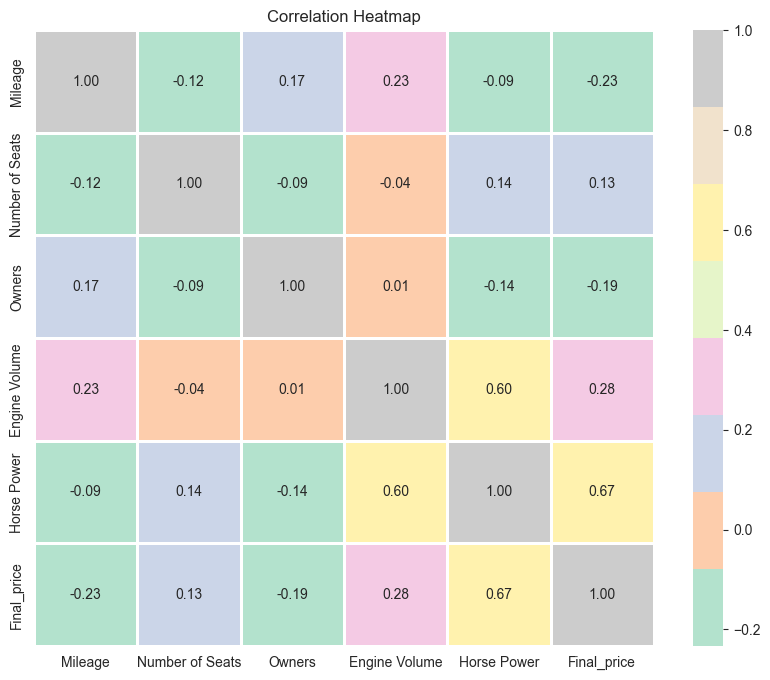

In [267]:

plt.figure(figsize=(10, 8))

sns.heatmap(df[numerical_columns].corr(), annot=True, fmt='.2f', cmap='Pastel2', linewidths=2)

plt.title('Correlation Heatmap')
plt.show()


In [268]:
categorical_cols = ['Brand', 'Model', 'Body Type', 'Color', 'Transmission', 'Drivetrain', 
                    'New', 'Market Assembled For', 'Region', 'Fuel', 'Has_Dents', 'Is_Painted']

numerical_cols = ['Year of Manufacture', 'Mileage', 'Number of Seats', 'Owners', 'Engine Volume', 'Horse Power']

In [269]:

X = df.drop(columns=['Final_price'])
y = df['Final_price']

In [270]:
preprocessor = ColumnTransformer([
    ('encoding', OneHotEncoder(handle_unknown='ignore'), categorical_cols), 
    ('scaling', RobustScaler(), numerical_cols) 
])

In [271]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [272]:
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('xgboost', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error (MSE): 114266558.36435325
R^2 Score: 0.9569746990487433


In [273]:
models = [
    ('XGBoost', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)),
    ('Random Forest', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('Gradient Boosting', GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ('SVR', SVR(C=1.0, kernel='rbf')),
    ('Linear Regression', LinearRegression())
]

results = []

for name, model in models:
    print(f"Training {name}...")
    pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('regressor', model)
    ])
    
    pipeline.fit(X_train, y_train)
    
    y_pred_train = pipeline.predict(X_train)  
    y_pred_test = pipeline.predict(X_test)  
    
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    

    results.append({
        'Model': name,
        'Train Mean Squared Error (MSE)': mse_train,
        'Test Mean Squared Error (MSE)': mse_test,
        'Train R^2 Score': r2_train,
        'Test R^2 Score': r2_test
    })

print("\nModel Performances:")
for result in results:
    print(f"{result['Model']} - Train MSE: {result['Train Mean Squared Error (MSE)']}, Test MSE: {result['Test Mean Squared Error (MSE)']}, Train R^2: {result['Train R^2 Score']}, Test R^2: {result['Test R^2 Score']}")


Training XGBoost...
Training Random Forest...
Training Gradient Boosting...
Training SVR...
Training Linear Regression...

Model Performances:
XGBoost - Train MSE: 62626831.076576866, Test MSE: 114266558.36435325, Train R^2: 0.9793402137343529, Test R^2: 0.9569746990487433
Random Forest - Train MSE: 21376107.046301086, Test MSE: 110405616.60291068, Train R^2: 0.9929482971567222, Test R^2: 0.9584284768085639
Gradient Boosting - Train MSE: 164633102.26011482, Test MSE: 192176859.54651505, Train R^2: 0.9456896565501536, Test R^2: 0.9276387830681734
SVR - Train MSE: 3272893670.2853794, Test MSE: 2875009197.6774993, Train R^2: -0.07968553630961339, Test R^2: -0.08254013893792411
Linear Regression - Train MSE: 436437354.39227843, Test MSE: 568159249.3462092, Train R^2: 0.8560249288509613, Test R^2: 0.7860684434599485


In [274]:
new_data_updated = pd.DataFrame({
    'Brand': ['Kia'],
    'Model': ['K5'],
    'Year of Manufacture': [2015],
    'Body Type': ['Sedan'],
    'Color': ['White'],
    'Mileage': [190000],
    'Transmission': ['Automatic'],
    'Drivetrain': ['Front'],
    'New': ['No'],
    'Number of Seats': [5],
    'Owners': [1],
    'Market Assembled For': ['South Korea'],
    'Region': ['Baku'],
    'Engine Volume': [1.7],
    'Horse Power': [141],
    'Fuel': ['Diesel'],
    'Has_Dents': ['No dents'],
    'Is_Painted': ['Not painted']
})

pipeline_linear_regression = Pipeline([
    ('preprocessing', preprocessor),
    ('Random Forest', RandomForestRegressor(n_estimators=100, random_state=42))
])

pipeline_linear_regression.fit(X_train, y_train)

predictions_updated = pipeline_linear_regression.predict(new_data_updated)

print(predictions_updated)


[29166.]
